# V(D)J Trajectory

This notebook is an identical notebook as per the quickstart tutorial with some additional information in the setup.

In [6]:
import dandelion as ddl
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import os

warnings.filterwarnings("ignore")

This notebook makes use of [Pertpy](https://github.com/scverse/pertpy) (previously [Milopy](https://github.com/emdann/milopy) [[Dann2022]](https://doi.org/10.1038/s41587-021-01033-z)) and [Palantir](https://github.com/dpeerlab/Palantir) [[Setty2019]](https://doi.org/10.1038/s41587-019-0068-4), two packages that are not formally Dandelion's dependencies. V(D)J feature space applications are open-ended, this is just one of them. Be sure to install the packages beforehand if you want to follow along.

In [9]:
# import milopy.core as milo 
import pertpy as pt # see issue https://github.com/emdann/milopy/issues/54
import palantir

#required because of Palantir
%matplotlib inline

sc.settings.set_figure_params(dpi=80)

We've prepared a demo object based on the TCR trajectory shown in the manuscript for you to use here. It's had some analysis done on the GEX, and has Dandelion-derived contig information merged into it. You can download it from the ftp site as per below or from this [demo repo](https://github.com/zktuong/dandelion-demo-files).

It's possible to use V(D)J information that comes from other sources than Dandelion processing, e.g. the pseudobulking will work with Scirpy output. The functions are just calibrated to work with Dandelion's structure by default.

In [3]:
if not os.path.exists("demo-pseudobulk.h5ad"):
    os.system("wget ftp://ftp.sanger.ac.uk/pub/users/kp9/demo-pseudobulk.h5ad")

The full data used in the Nature Biotechnology paper is available at a separate [repository](https://github.com/zktuong/dandelion-demo-files/tree/master/dandelion_manuscript).

Prior to performing the pseudobulking, it is recommended to run `ddl.tl.setup_vdj_pseudobulk()`. This will subset the object to just cells with paired chains, and prepare appropriately named and formatted columns for the pseudobulking function to use as defaults.

If working with non-Dandelion V(D)J processing, subset your cells to ones with at least a full pair of chains, and ensure that you have four columns in place which contain the V(D)J calls for both of the identified primary chains. Scirpy stores this information natively.

If you are wanting to include D calls (disabled by default), the recommendation is to subset to only cells/contigs with d_call annotated otherwise the separation could be unreliable (due to missing d_call because of technical reasons rather than biology).

Please look at the options for `ddl.tl.setup_vdj_pseudobulk()` carefully to tailor to your use case.

<div class="alert alert-info">

Different setup options/examples
    
Example #1: if you are wanting to use ALL contigs, regardless of whether they are productive, you would to toggle:
<br>
```python
ddl.tl.setup_vdj_pseudobulk(adata, productive_vdj = False, productive_vj = False)
```
<br>
    
Example #2: if you are wanting to use just productive J chains (i.e. you don't mind that V gene is not annotated or not productive) you would to toggle:
<br>
```python
ddl.tl.setup_vdj_pseudobulk(adata, 
    productive_vdj = False,
    productive_vj = True,
    check_vdj_mapping = None,
    check_vj_mapping = ["j_call"])
```
<br>

Example #3: if you are wanting to do it only BCR, gdTCR, abTCR(default), toggle the `mode` option:
<br>
```python
ddl.tl.setup_vdj_pseudobulk(adata, mode = 'B')
ddl.tl.setup_vdj_pseudobulk(adata, mode = 'gdT')
ddl.tl.setup_vdj_pseudobulk(adata, mode = 'abT')
```
<br>

Example #4: if you want to customise the input (e.g. ignore default columns and using both abT and gdT), you can adjust to the following:
<br>
```python
ddl.tl.setup_vdj_pseudobulk(adata,
    mode = None,
    extract_cols = ['v_call_VDJ', 'd_call_VDJ', 'j_vall_VDJ', 'v_call_VJ', 'j_call_VJ']
    check_extract_cols_mapping = ['v_call_VDJ', 'd_call_VDJ', 'j_vall_VDJ', 'v_call_VJ', 'j_call_VJ']) # this should be identical to extract_cols
``` 
<br>
specifying `check_vdj_mapping`, `check_vj_mapping`, and/or `check_extract_cols_mapping` as `None` means that all cells will be used (including those without immune receptors; not advised).
    
</div>

We will proceed with the default settings, which is to only consider the primary V and J calls (productive and highest UMI).

In [4]:
adata = sc.read("demo-pseudobulk.h5ad")
adata = ddl.tl.setup_vdj_pseudobulk(adata)

We're going to be using Milopy to create pseudobulks. Construct a neighbour graph with many neighbours, following Milopy protocol, and then sample representative neighbourhoods from the object. This saves a cell-by-pseudobulk matrix into `adata.obsm["nhoods"]`. Use this graph to generate a UMAP as well.

In [10]:
sc.pp.neighbors(adata, use_rep="X_scvi", n_neighbors=50)

milo = pt.tl.Milo()
milo.make_nhoods(adata)
sc.tl.umap(adata)

Now we are armed with everything we need to construct the V(D)J feature space. Pseudobulks can be defined either via passing a list of `.obs` metadata columns, the unique values of the combination of which will serve as individual pseudobulks (via `obs_to_bulk`), or via an explicit cell-by-pseudobulk matrix (via `pbs`). Milopy created one of those for us, so we can use that as input.

The cell type annotation lives in `.obs["anno_lvl_2_final_clean"]`. Let's tell the function that we want to take the most common value per pseudobulk with us to the new V(D)J feature space object.

For non-Dandelion V(D)J processing, use the `cols` argument to specify which `.obs` columns contain the V(D)J calls for the identified primary chains. For Scirpy, this would mean specifying e.g. `cols = ['IR_VDJ_1_v_gene', 'IR_VDJ_1_j_gene', 'IR_VJ_1_v_gene', 'IR_VJ_1_j_gene']`.

In [12]:
pb_adata = ddl.tl.vdj_pseudobulk(
    adata, pbs=adata.obsm["nhoods"], obs_to_take="anno_lvl_2_final_clean"
)

There is a similar function `ddl.tl.pseudobulk_gex` that takes similar options but pseudobulks the gene expression data instead of making the VDJ feature space.

The new object has pseudobulks as observations, and the unique encountered V(D)J genes as the features. We can see the per-pseudobulk annotation, and `.uns["pseudobulk_assigments"]`. In our case it's just a copy of the `pbs` argument, but if we were to go for `obs_to_bulk` this would be a cells by pseudobulks matrix capturing the assignment of the original cells.

In [13]:
pb_adata

AnnData object with n_obs × n_vars = 1341 × 160
    obs: 'anno_lvl_2_final_clean', 'anno_lvl_2_final_clean_fraction', 'cell_count'
    obsm: 'pbs'

Now that we have our V(D)J feature space pseudobulk object, we can do things with it. Let's run a PCA on it. The development trajectory is very nicely captured in the first two PC dimensions.

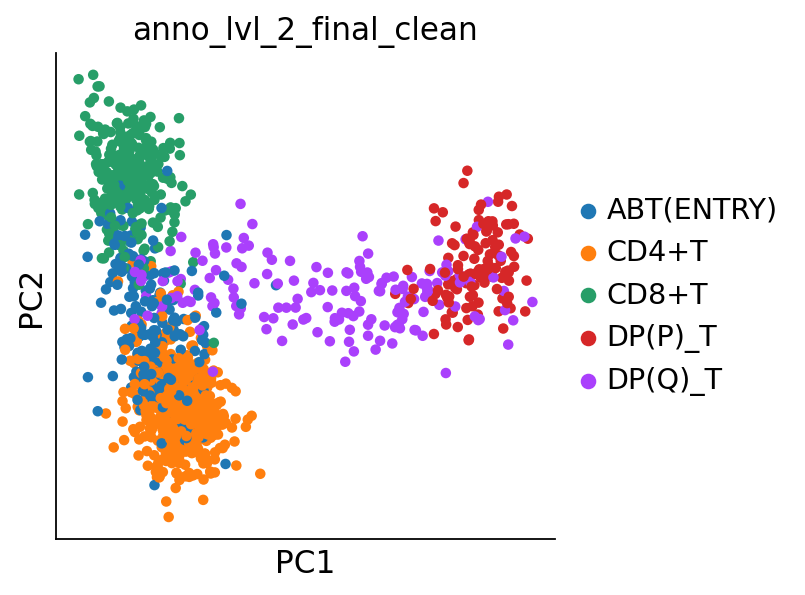

In [14]:
sc.tl.pca(pb_adata)
sc.pl.pca(pb_adata, color="anno_lvl_2_final_clean")

Let's define the start of our trajectory as the right-most cell, the CD4 terminal state as the bottom-most cell, and the CD8 terminal state as the top-most cell. We can then follow Palantir protocol to generate a diffusion map and run pseudotime. Once done, we rename the terminal states to be more informative.

In [15]:
rootcell = np.argmax(pb_adata.obsm["X_pca"][:, 0])
terminal_states = pd.Series(
    ["CD8+T", "CD4+T"],
    index=pb_adata.obs_names[
        [
            np.argmax(pb_adata.obsm["X_pca"][:, 1]),
            np.argmin(pb_adata.obsm["X_pca"][:, 1]),
        ]
    ],
)

# Run diffusion maps
pca_projections = pd.DataFrame(pb_adata.obsm["X_pca"], index=pb_adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = ms_data.index.astype(str)

pr_res = palantir.core.run_palantir(
    ms_data,
    pb_adata.obs_names[rootcell],
    num_waypoints=500,
    terminal_states=terminal_states.index,
)

pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

Sampling and flocking waypoints...
Time for determining waypoints: 0.000889126459757487 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.49282257159550985 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


We can easily transfer the inferred pseudotime and branching probabilities to the pseudobulk object with the aid of a helper function.

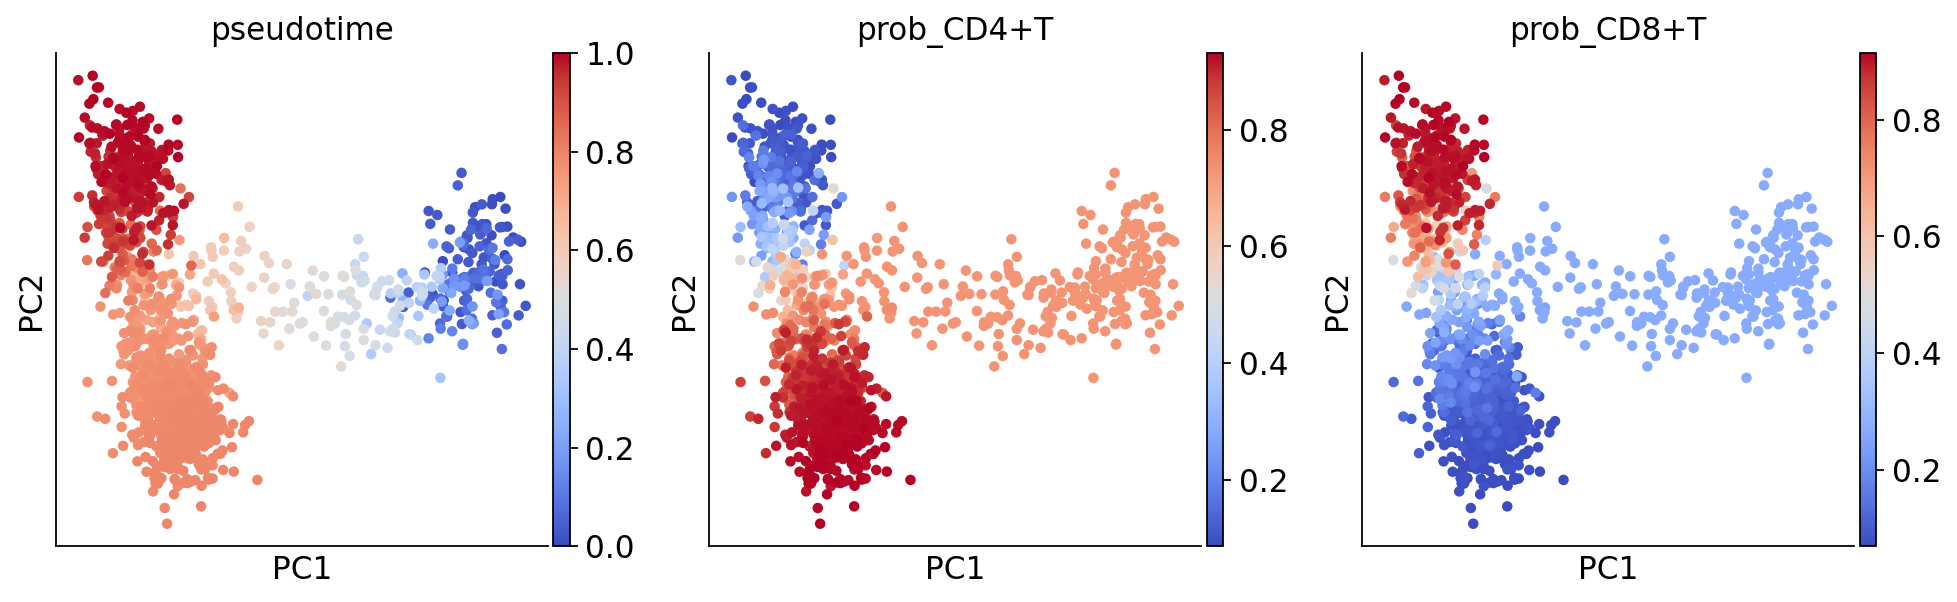

In [16]:
pb_adata = ddl.tl.pseudotime_transfer(pb_adata, pr_res)
sc.pl.pca(
    pb_adata,
    color=["pseudotime", "prob_CD4+T", "prob_CD8+T"],
    color_map="coolwarm",
)

We can project back our findings to the original cell space object via another helper function. This will remove any cells not in any of the pseudobulks. In the event of a cell belonging to multiple pseudobulks, the cell's pseudotime will be the average of the pseudobulks weighted by the inverse of the pseudobulk size.

number of cells removed due to not belonging to any neighbourhood 87


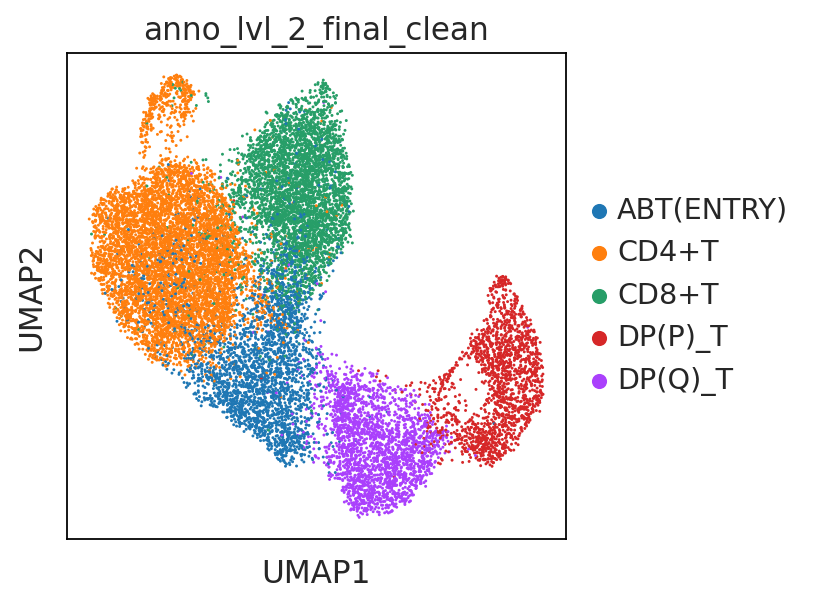

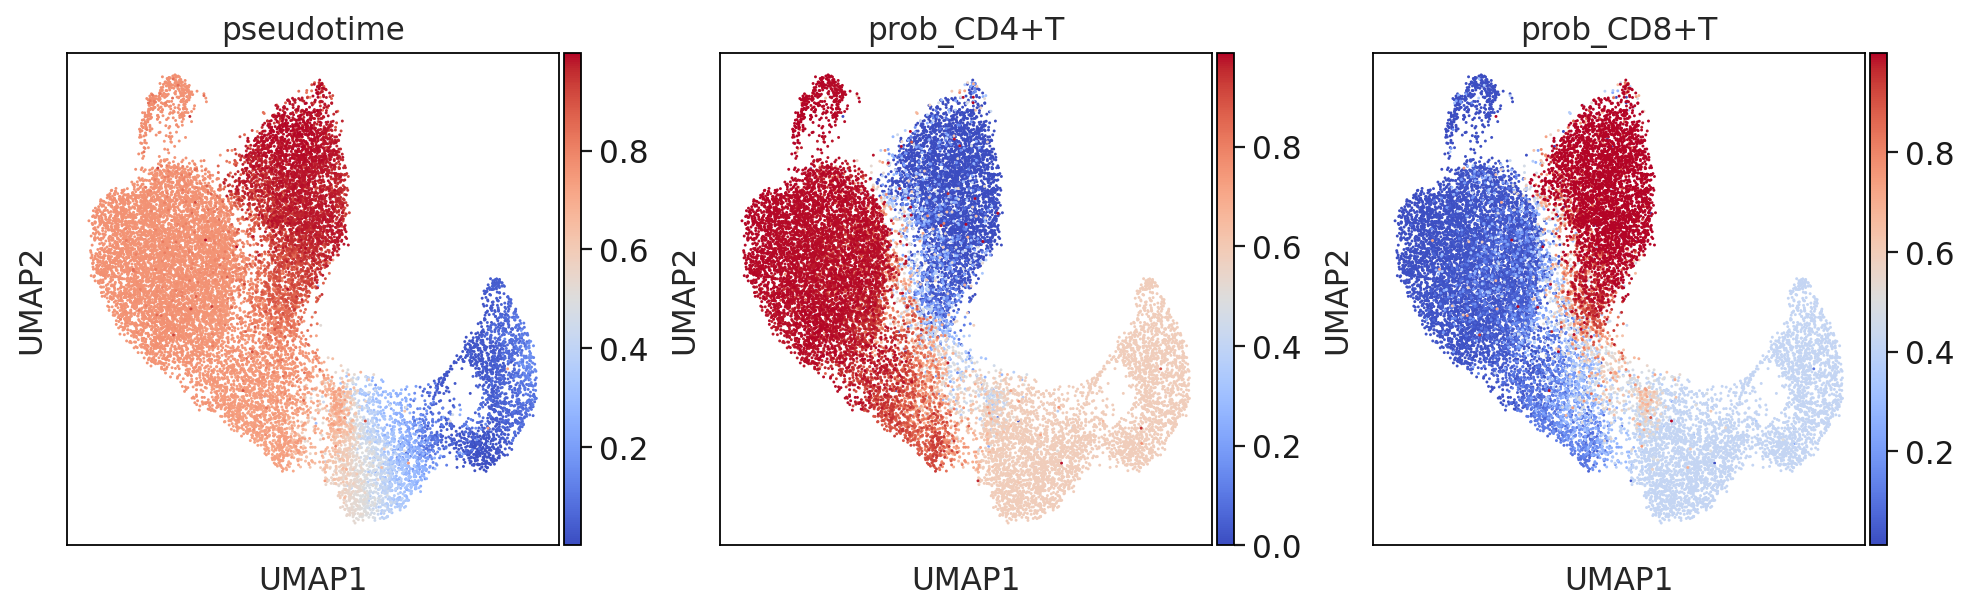

In [11]:
bdata = ddl.tl.project_pseudotime_to_cell(
    adata, pb_adata, terminal_states.values
)
sc.pl.umap(bdata, color=["anno_lvl_2_final_clean"])
sc.pl.umap(
    bdata,
    color=["pseudotime", "prob_CD4+T", "prob_CD8+T"],
    color_map="coolwarm",
)